In [5]:
pip install -q seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q git+https://github.com/tensorflow/docs

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tf-nightly --user

  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached tb_nightly-2.3.0a20200416-py3-none-any.whl (3.0 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorboard_plugin_wit-1.6.0.post3-py3-none-any.whl (777 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: tensorflow 2.1.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [71]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [72]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0-dev20200417


In [73]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [74]:
dataset_path = keras.utils.get_file("Expenses.csv", "https://www.kaggle.com/trinaghosh346/personal-income-expenditure/download/")
dataset_path

'C:\\Users\\Lillis\\.keras\\datasets\\Expenses.csv'

In [75]:
column_names = ['Date','WeekDay','Amount','Category','Description','Source']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,Date,WeekDay,Amount,Category,Description,Source
1015,9/30/19,Monday,-420,Bills,Rent,Chase Debit Card
1016,9/30/19,Monday,-19.35,Merchandise,Amazon,American Express Credit Card
1017,9/30/19,Monday,-16.14,Merchandise,Clothes,American Express Credit Card
1018,9/30/19,Monday,-10.35,Uber/Lyft,NaN,Chase Debit Card
1019,9/30/19,Monday,-8.63,Merchandise,Amazon,American Express Credit Card


In [76]:
dataset.isna().sum()

Date             0
WeekDay          0
Amount           0
Category         0
Description    513
Source           0
dtype: int64

In [77]:
dataset = dataset.drop(0)

In [78]:
# Separating the date 
# new data frame with split value columns 
new = dataset["Date"].str.split("/", n = 2, expand = True) 
  
# making separate column for day 
dataset["Month"]= pd.to_numeric(new[0]) 
  
# making separate column for month 
dataset["Day"]= pd.to_numeric(new[1])

# making separate column for year
dataset["Year"]= pd.to_numeric(new[2]) 
dataset["Entry"] = pd.to_numeric(dataset.Month+(200000)+(dataset.Year*100))


In [79]:
#create a column indicating if the amount is a debit or credit 
dataset.Amount = pd.to_numeric(dataset.Amount)

def test(c):
  if c["Amount"] < 0:
    return 0
  else: 
    return 1

dataset["Debit"] = pd.to_numeric(dataset.apply(test, axis=1))

In [80]:
#converting values from days of the week
weekday = {'Monday': 1,'Tuesday': 2,'Wednesday' :3,'Thursday':4,'Friday' : 5,'Saturday' :6, 'Sunday':7, 'Day of the Week':0} 
dataset.WeekDay = [weekday[item] for item in dataset.WeekDay]
#converting values from categories
category = {'Bills': 1,'Groceries': 2,'Merchandise' :3,'Wire Transfer':4,'Travel' : 5,'Pharmacy' :6, 'Food':7, 'Uber/Lyft':8, 'Direct Deposit': 9, 'Tuition': 10, 'Entertainment':11, 'Category':0, 'Other': 12} 
dataset.Category = [category[item] for item in dataset.Category]

In [81]:
dataset = dataset.drop('Source', 1)
dataset = dataset.drop('Description', 1)
#dataset = dataset.drop('Day',1)
dataset = dataset.drop('Month',1)
dataset = dataset.drop('Year',1)
dataset = dataset.drop('Date',1)

dataset = dataset.infer_objects()
dataset.dtypes

dataset.Amount = abs(pd.to_numeric(dataset.Amount))
dataset["Week"]= pd.to_numeric(dataset.WeekDay)
dataset = dataset.drop('WeekDay',1)

In [82]:
dataset.head()

,Amount,Category,Day,Entry,Debit,Week
1,1360.00,1,3,201808,0,5
2,117.89,2,4,201808,0,6
3,34.27,3,4,201808,0,6
4,21.59,3,4,201808,0,6
5,10.79,3,5,201808,0,7


In [83]:
#group the expenses by month and category
dataset.groupby(by=["Entry","Category"])["Amount"].sum()

Entry   Category
201808  1            1360.00
        2             224.89
        3             229.77
        4            2500.00
        5              70.00
                      ...   
201909  8             196.95
        9            1001.41
        10          52258.44
        11             95.23
        12             23.40
Name: Amount, Length: 118, dtype: float64

In [84]:
dataset = dataset.drop(dataset[dataset.Debit == int(1)].index)

In [85]:
dataset = dataset.drop('Debit',1)
dataset = dataset.drop('Day',1)
dataset = dataset.drop('Week',1)
dataset = dataset.drop('Entry',1)

In [86]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

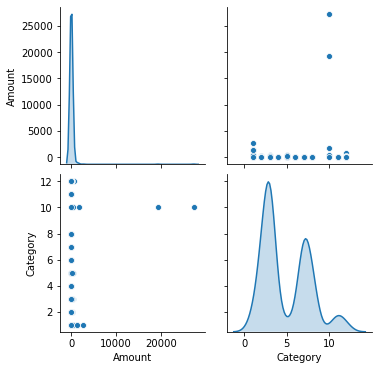

In [87]:
sns.pairplot(train_dataset[["Amount","Category"]], diag_kind="kde")

In [88]:
train_stats = train_dataset.describe()
train_stats.pop("Category")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Amount,714.0,112.583389,1261.772097,0.24,7.75,15.0,32.39,27308.44


In [89]:
train_labels = train_dataset.pop('Category')
test_labels = test_dataset.pop('Category')

In [20]:
dataset = dataset.infer_objects()
dataset.dtypes

Amount      float64
Category      int64
dtype: object

In [21]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [54]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])


  return model

In [55]:
model = build_model()

In [56]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [57]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.01399289],
       [-0.01311055],
       [-0.013819  ],
       [-0.01256956],
       [-0.0128465 ],
       [-0.00939443],
       [-0.01371982],
       [-0.01419641],
       [-0.01241627],
       [-0.010792  ]], dtype=float32)

In [58]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:29.1826,  mean_absolute_error:4.6483,  mean_squared_error:29.1518,  val_loss:29.7922,  val_mean_absolute_error:4.7295,  val_mean_squared_error:29.7827,  
....................................................................................................
Epoch: 100, loss:7.0054,  mean_absolute_error:2.3471,  mean_squared_error:7.0235,  val_loss:7.0730,  val_mean_absolute_error:2.3293,  val_mean_squared_error:6.8881,  
....................................................................................................
Epoch: 200, loss:6.6819,  mean_absolute_error:2.2138,  mean_squared_error:6.6614,  val_loss:6.7452,  val_mean_absolute_error:2.2247,  val_mean_squared_error:6.5926,  
....................................................................................................
Epoch: 300, loss:6.6911,  mean_absolute_error:2.1964,  mean_squared_error:6.6921,  val_loss:6.7457,  val_mean_absolute_error:2.1938,  val_mean_squared_error:6.6537,  
..........................

In [59]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,6.580622,2.194835,6.585453,6.868747,2.182523,6.816987,995
996,6.609555,2.188405,6.620222,6.767685,2.182944,6.689724,996
997,6.535340,2.188392,6.556233,6.761369,2.180135,6.683632,997
998,6.633740,2.181407,6.590583,6.755887,2.184834,6.665865,998
999,6.571566,2.191352,6.582506,6.759444,2.180991,6.679270,999


In [60]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [Category]')

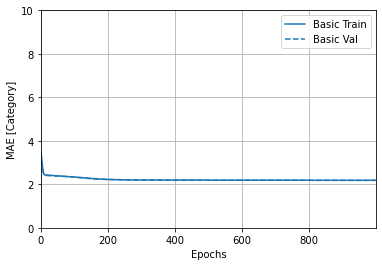

In [61]:
plotter.plot({'Basic': history}, metric = "mean_absolute_error")
plt.ylim([0, 10])
plt.ylabel('MAE [Category]')

Text(0, 0.5, 'MSE [Category^2]')

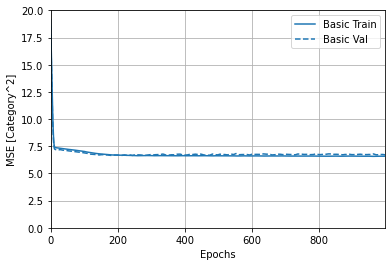

In [62]:
plotter.plot({'Basic': history}, metric = "mean_squared_error")
plt.ylim([0, 20])
plt.ylabel('MSE [Category^2]')

In [63]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:30.3280,  mean_absolute_error:4.7493,  mean_squared_error:30.4002,  val_loss:31.1550,  val_mean_absolute_error:4.8747,  val_mean_squared_error:31.1535,  
....................................................................................................
Epoch: 100, loss:7.0528,  mean_absolute_error:2.3412,  mean_squared_error:7.0228,  val_loss:7.0331,  val_mean_absolute_error:2.3505,  val_mean_squared_error:6.8306,  
................................................................................................

Text(0, 0.5, 'MAE [Category]')

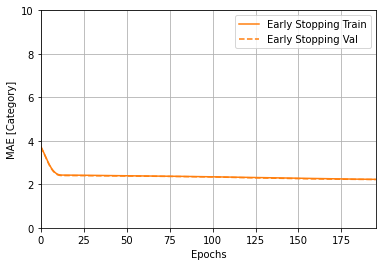

In [64]:
plotter.plot({'Early Stopping': early_history}, metric = "mean_absolute_error")
plt.ylim([0, 10])
plt.ylabel('MAE [Category]')

In [65]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

6/6 - 0s
Testing set Mean Abs Error:  2.13 MPG


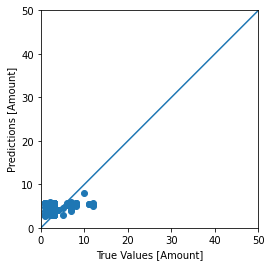

In [66]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Amount]')
plt.ylabel('Predictions [Amount]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

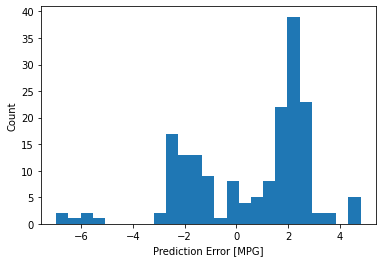

In [67]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [68]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/assets


In [69]:
# Converting ConcreteFunctions to a TensorFlow Lite model.
# converter = tf.lite.TFLiteConverter.from_concrete_functions(allow_custom_ops=True)
#tflite_model = converter.convert()


converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
converter.allow_custom_ops=True
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('MyPAMmodel.tflite')
tflite_model_file.write_bytes(tflite_model)

19132